<a href="https://colab.research.google.com/github/Harishankarvel/LAUN_ML_project/blob/main/XGBoost_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset 'ODI.csv' loaded successfully from the Colab session.
Starting advanced feature engineering...
Feature engineering complete.

Starting hyperparameter tuning with XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:42:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best model parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

--- Final Tuned Model Evaluation (XGBoost) ---
Final Accuracy: 61.57%

Classification Report:
              precision    recall  f1-score   support

        Loss       0.58      0.68      0.63       121
         Win       0.66      0.56      0.60       134

    accuracy                           0.62       255
   macro avg       0.62      0.62      0.62       255
weighted avg       0.62      0.62      0.61       255


Generating graphical representations...


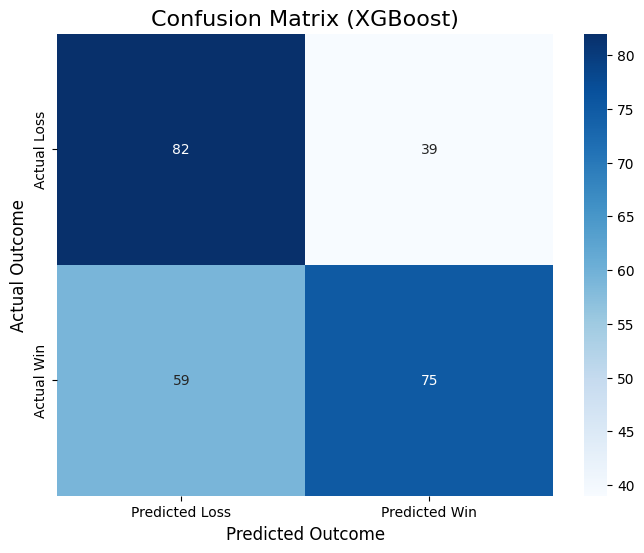

/tmp/ipython-input-1109763461.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


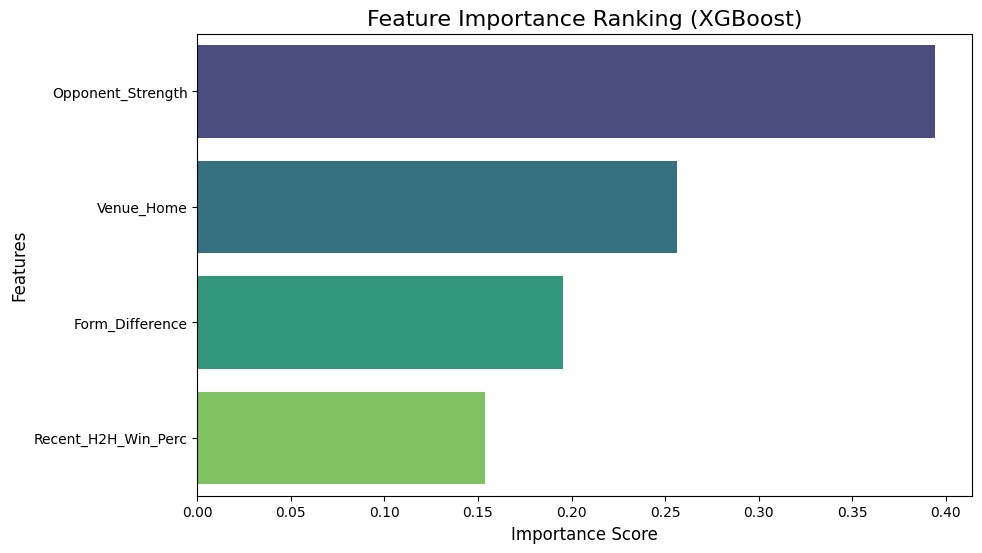

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Loading and Initial Cleaning ---
try:
    df_raw = pd.read_csv('ODI.csv')
    print("Dataset 'ODI.csv' loaded successfully from the Colab session.")
except FileNotFoundError:
    print("ERROR: 'ODI.csv' not found. Please upload the file to your Colab session.")
    exit()

df_raw.rename(columns={'Team_1': 'Team 1', 'Team_2': 'Team 2'}, inplace=True)
df_raw['Date'] = pd.to_datetime(df_raw['Match Date'], errors='coerce')
df_raw.dropna(subset=['Date', 'Winner', 'Team 1', 'Team 2', 'Ground'], inplace=True)
df_raw = df_raw.sort_values('Date').reset_index(drop=True)

# --- 2. Advanced Feature Engineering ---

def get_team_form(df, team_name, date):
    team_matches = df[((df['Team 1'] == team_name) | (df['Team 2'] == team_name)) & (df['Date'] < date)]
    if len(team_matches) == 0:
        return 50.0
    last_10_matches = team_matches.tail(10)
    wins = (last_10_matches['Winner'] == team_name).sum()
    return (wins / len(last_10_matches)) * 100

df_india = df_raw[(df_raw['Team 1'] == 'India') | (df_raw['Team 2'] == 'India')].copy()
df_india['India_Won'] = (df_india['Winner'] == 'India').astype(int)
df_india['Opponent'] = df_india.apply(lambda row: row['Team 2'] if row['Team 1'] == 'India' else row['Team 1'], axis=1)

print("Starting advanced feature engineering...")
forms = df_india.apply(lambda row: (get_team_form(df_india, 'India', row['Date']), get_team_form(df_raw, row['Opponent'], row['Date'])), axis=1)
df_india['India_Form_Last_10'] = [form[0] for form in forms]
df_india['Opponent_Form_Last_10'] = [form[1] for form in forms]

df_india['Form_Difference'] = df_india['India_Form_Last_10'] - df_india['Opponent_Form_Last_10']

df_india['Recent_H2H_Wins'] = df_india.groupby('Opponent')['India_Won'].transform(lambda x: x.shift(1).rolling(10, min_periods=1).sum())
df_india['Recent_H2H_Matches'] = df_india.groupby('Opponent')['India_Won'].transform(lambda x: x.shift(1).rolling(10, min_periods=1).count())
df_india['Recent_H2H_Win_Perc'] = (df_india['Recent_H2H_Wins'] / df_india['Recent_H2H_Matches']).fillna(50)

indian_cities = ['Mumbai', 'Kolkata', 'Delhi', 'Chennai', 'Bangalore', 'Hyderabad', 'Ahmedabad', 'Pune', 'Jaipur', 'Kanpur', 'Nagpur', 'Mohali', 'Indore']
df_india['Venue'] = df_india['Ground'].apply(lambda ground: 'Home' if any(city in ground for city in indian_cities) else 'Away_Neutral')

team_wins = df_raw['Winner'].value_counts()
team_matches = pd.concat([df_raw['Team 1'], df_raw['Team 2']]).value_counts()
df_india['Opponent_Strength'] = df_india['Opponent'].map((team_wins / team_matches).fillna(0) * 100)
print("Feature engineering complete.")

# --- 3. Data Preparation ---
df_model = pd.get_dummies(df_india, columns=['Venue'], drop_first=True)
features = ['Opponent_Strength', 'Form_Difference', 'Recent_H2H_Win_Perc', 'Venue_Home']
target = 'India_Won'

df_model.dropna(subset=features, inplace=True)
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- 4. Hyperparameter Tuning (with XGBoost) ---
print("\nStarting hyperparameter tuning with XGBoost...")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("\nBest model parameters found:", grid_search.best_params_)

# --- 5. Final Model Evaluation ---
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Final Tuned Model Evaluation (XGBoost) ---")
print(f"Final Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Win']))

# --- 6. Graphical Representations ---
print("\nGenerating graphical representations...")
# a) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))

# --- THIS IS THE CORRECTED LINE ---
# 'ylabels' has been changed to 'yticklabels'
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Loss', 'Predicted Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
# --- END OF CORRECTION ---

plt.title('Confusion Matrix (XGBoost)', fontsize=16)
plt.ylabel('Actual Outcome', fontsize=12)
plt.xlabel('Predicted Outcome', fontsize=12)
plt.show()

# b) Feature Importance Plot
importance_df = pd.DataFrame({'Feature': features, 'Importance': best_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Ranking (XGBoost)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()